In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
import cv2
# from temp_004 import psf2otf

In [2]:
degree = 7
angle = 60

def PSF(degree,angle):
    M = cv2.getRotationMatrix2D((round(degree / 2), round(degree / 2)), angle, 1)
    motion_blur_kernel = np.diag(np.ones(degree))# degree = 7
    motion_blur_kernel = cv2.warpAffine(motion_blur_kernel, M, (degree, degree))
    PSF = motion_blur_kernel / degree
    
    return PSF


# PSF.shape

In [3]:
def psf2otf(psf, outSize):
    psfSize = np.array(psf.shape)
    outSize = np.array(outSize)
    padSize = outSize - psfSize
    psf = np.pad(psf, ((0, padSize[0]), (0, padSize[1])), 'constant')
    for i in range(len(psfSize)):
        psf = np.roll(psf, -int(psfSize[i] / 2), i)
    otf = np.fft.fftn(psf)
    nElem = np.prod(psfSize)
    nOps = 0
    for k in range(len(psfSize)):
        nffts = nElem / psfSize[k]
        nOps = nOps + psfSize[k] * np.log2(psfSize[k]) * nffts
    if np.max(np.abs(np.imag(otf))) / np.max(np.abs(otf)) <= nOps * np.finfo(np.float32).eps:
        otf = np.real(otf)
    return otf

def wiener(blurred, PF, SNR=0.001):       # 维纳滤波，K=0.01
    IF_fft = fft.fft2(blurred)
    G_f = np.conj(PF) / (np.abs(PF) ** 2 + SNR)
    result = fft.ifft2(IF_fft * G_f)
    result = np.real(result)
    return result

# 实现方法二
# def wiener(input,PSF,K=0.01):        #维纳滤波，K=0.01
#     input_fft=np.fft.fft2(input)
#     PSF_fft=np.fft.fft2(PSF)
#     PSF_fft_1=np.conj(PSF_fft) /(np.abs(PSF_fft)**2 + K)
#     result=np.fft.ifft2(input_fft * PSF_fft_1)
#     result=np.real(fft.fftshift(result))
#     result[result > 255.0] = 255
#     result[result < 0] = 0
#     return result

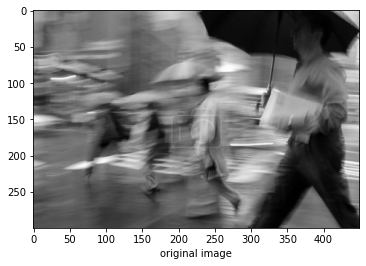

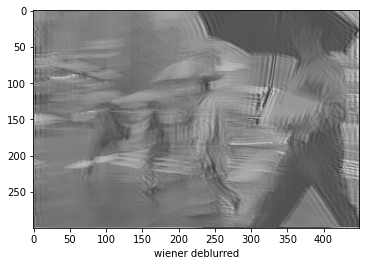

In [4]:
import matplotlib.pyplot as graph

image = cv2.imread('2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

img_h = image.shape[0]
img_w = image.shape[1]
outSize = [img_h,img_w]

# 显示原图像
graph.figure()
graph.xlabel("original image")
graph.gray()
graph.imshow(image)

PSF = PSF(degree=7,angle=60)
PF = psf2otf(PSF,outSize)


# 维纳滤波
result = wiener(image,PF,0.01)

# result = wiener(blurred, PSF, 1e-3)  # 维纳滤波
# graph.subplot(233)
# graph.xlabel("wiener deblurred(k=0.01)")
# graph.imshow(result)

# 显示wiener deblurred之后的图像
graph.figure(233)
graph.xlabel("wiener deblurred")
graph.gray()
graph.imshow(result)